In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot

from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *

In [5]:
def read_tag_from_wandb(tag):
    # read yolov7 runs
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path ="nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs: 
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        if 'val_dice_scores/class_Unknown' not in dicto.keys() or dicto['epoch'] < 4: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[['label', 'val_dice_score', 'num_samples_per_epoch']]

    #assert ret_df.shape[0] == 102
    #assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

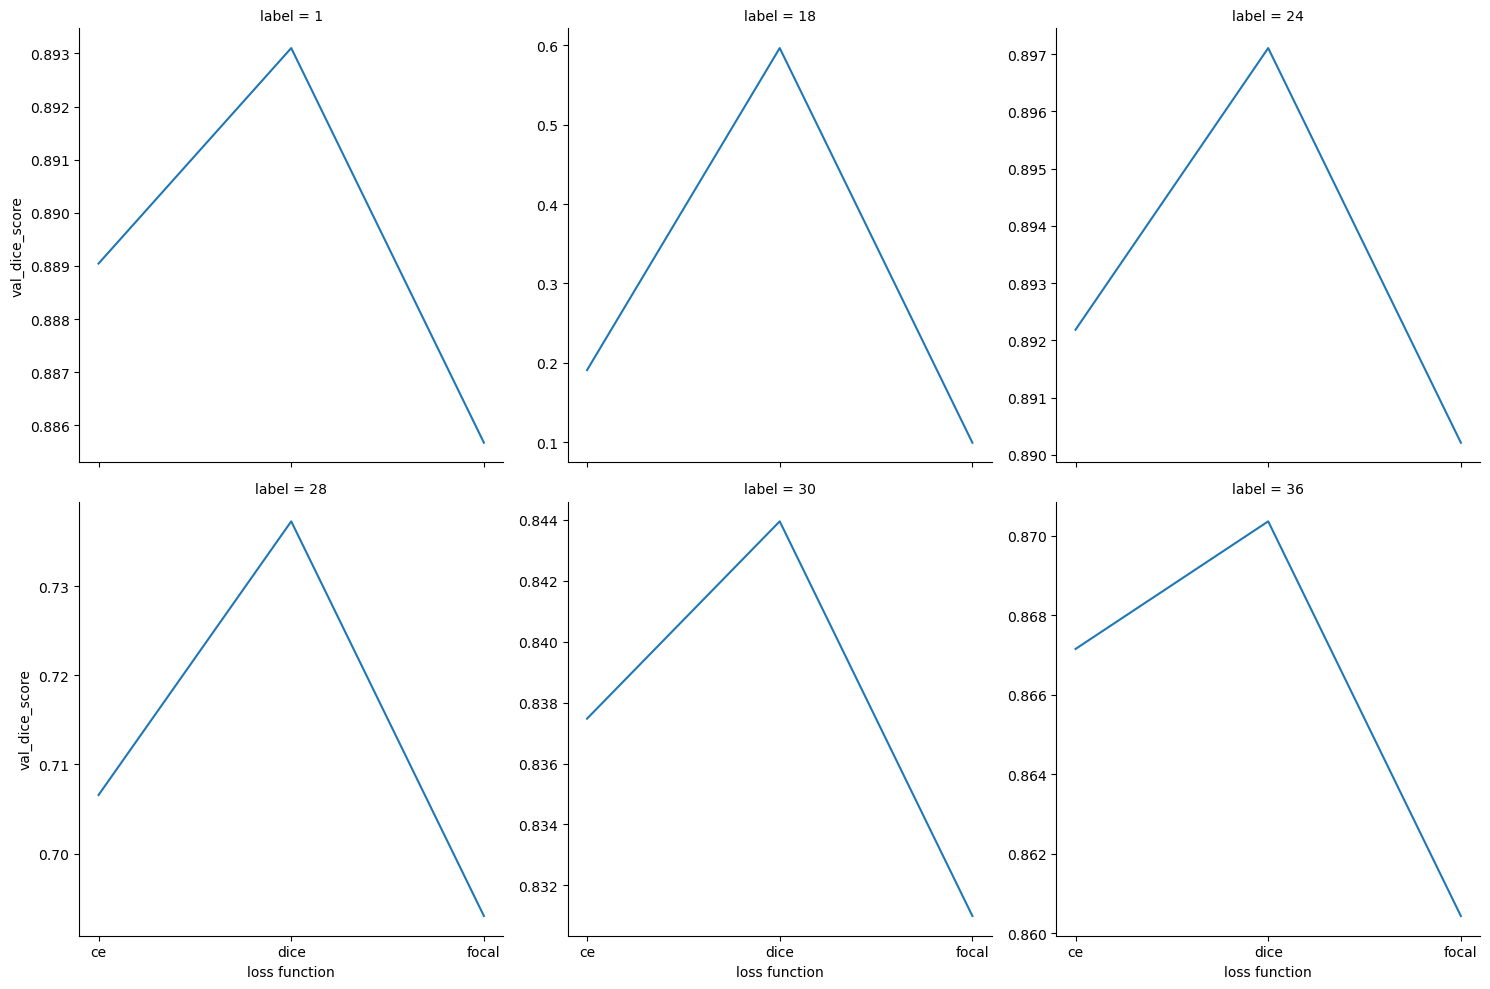

In [26]:
df_ce = read_tag_from_wandb('ce')
df_ce['loss function'] = 'ce'
df_dice = read_tag_from_wandb('dice')
df_dice['loss function'] = 'dice'
df_focal = read_tag_from_wandb('focal')
df_focal['loss function'] = 'focal'

df_combined = pd.concat([df_ce, df_dice, df_focal], axis=0)
dicto = {'ce':0, 'focal':1, 'dice':2}
df_combined['numerical_x'] = df_combined['loss function'].map(dicto)

sns.relplot(x = 'loss function', y = 'val_dice_score', col='label', data = df_combined, kind='line', col_wrap=3, facet_kws = {'sharey':False})